# Data Visualization Notebook

## Objectives

*   Answer business requirement 1: 
    * The client is interested to have a study to visually differentiate an parasitized and uninfected cell.


## Inputs

* inputs/malaria_dataset

## Outputs

* Labels distribution on train, validation and test set plot
* Image shape embeddings pickle file
* Mean and variability of images per label plot
* Plot to distinguish contrast between parasite-contained and uninfected cell images
* Generate code that answers business requirement 1 and can be used to build image montage on Streamlit dashboard


## Additional Comments | Insights | Conclusions




---

# Set Data Directory

---

## Import libraries

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set working directory

In [23]:
work_dir = '/workspace/WalkthroughProject01'
work_dir

'/workspace/WalkthroughProject01'

## Set input directories

Set train, validation and test paths

In [24]:
my_data_dir = 'inputs/malaria_dataset/cell_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [25]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


---

# Data visualisation of image data

## Plot and save labels distribution

### Labels Exploration

In [26]:
labels_train = os.listdir(train_path)
labels_test = os.listdir(test_path)
labels_val = os.listdir(val_path)

print(
    f"Labels on train set: {labels_train}\n"
    f"Labels on validation set: {labels_val}\n"
    f"Labels on test set: {labels_test}\n"
    )

Labels on train set: ['Parasitized', 'Uninfected']
Labels on validation set: ['Parasitized', 'Uninfected']
Labels on test set: ['Parasitized', 'Uninfected']



### Set label names

In [27]:
# Set the labels
labels = os.listdir(train_path)
print('Label for the images are',labels)

Label for the images are ['Parasitized', 'Uninfected']


### Plot label distribution and save the plot.

* train set - Parasitized: 3950 images
* train set - Uninfected: 3950 images
* validation set - Parasitized: 564 images
* validation set - Uninfected: 564 images
* test set - Parasitized: 1129 images
* test set - Uninfected: 1129 images




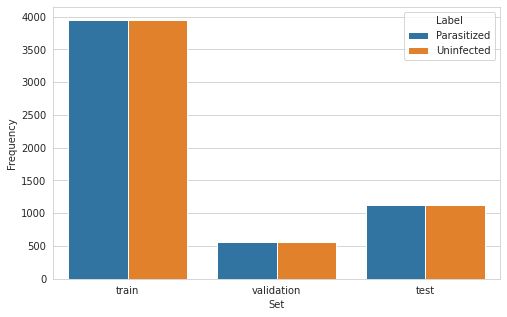

In [28]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} set - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()


---

## Image shape 

Compute average images' size on train set

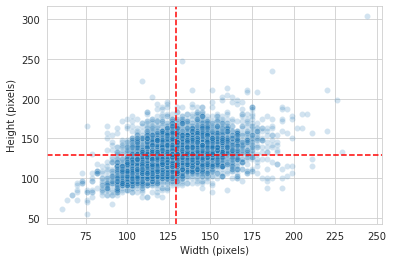

Width average: 129 
Height average: 129


In [29]:
dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_path + '/'+ label):
    img = imread(train_path + '/' + label + '/'+ image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1) # image height
    dim2.append(d2) # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean,color='r', linestyle='--')
axes.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

Images size for training the model is the average from all image in train set

In [30]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(129, 129, 3)

Save the image shape embeddings

In [31]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Average and variability of images  per label

### Function to load images in an array (tensor)

In [32]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50,50), n_images_per_label = 20):
  
  X, y = np.array([], dtype='int'), np.array([], dtype='object')
  labels = os.listdir(my_data_dir)

  for label in labels:
    counter = 0
    for image_filename in os.listdir(my_data_dir + '/' + label):
      # n_images_per_label: we set a limit, since it may take too much time
      if counter < n_images_per_label:
        
        img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
        if image.img_to_array(img).max() > 1: 
          img_resized = image.img_to_array(img) / 255
        else: 
          img_resized = image.img_to_array(img)
        
        X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y

### Load image shape and labels in array

In [33]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                          n_images_per_label = 30)
print(X.shape, y.shape)

(60, 129, 129, 3) (60,)


### Plot and save mean and variability of images per label

In [34]:
def plot_mean_variability_per_labels(X, y, figsize=(12,5), save_image=False):
  """
   The pseudo code for the function is:
  * Loop in all labels
  * Subset an array for given label
  * Calculate mean and standard deviation
  * Create a figure displaying mean and variability of images
  * Save image

  """

  for label_to_display in np.unique(y):
    sns.set_style("white")

    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
    arr = X[boolean_mask]

    avg_img = np.mean(arr, axis = 0)
    std_img = np.std(arr, axis = 0)
    print(f"==== Label {label_to_display} ====")
    print(f"Image Shape: {avg_img.shape}")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title(f"Average Image for label {label_to_display}")
    axes[0].imshow(avg_img, cmap='gray')
    axes[1].set_title(f"Variability image for label {label_to_display}")
    axes[1].imshow(std_img, cmap='gray')

    if save_image:
      plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()
      print("\n")

==== Label Parasitized ====
Image Shape: (129, 129, 3)
==== Label Uninfected ====
Image Shape: (129, 129, 3)


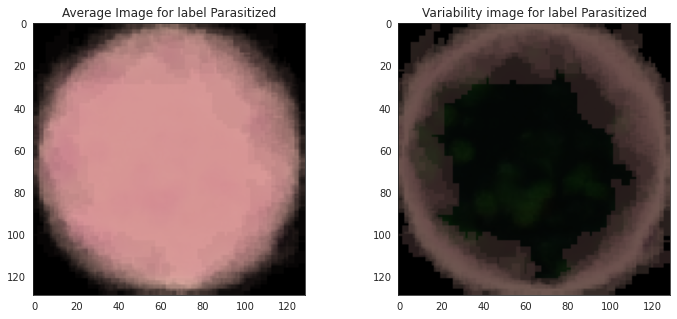

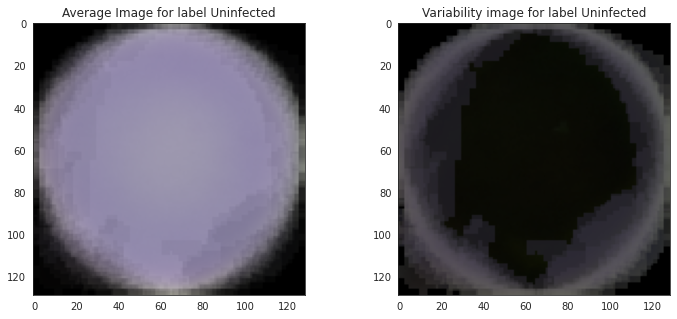

In [35]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12,5),save_image=True)

---

## Difference between average parasite-contained and average uninfected cell images

---

In [36]:
def subset_image_label(X,y,label_to_display):
  y = y.reshape(-1,1,1)
  boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
  df = X[boolean_mask]
  return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(12,5), save_image=False):
  sns.set_style("white")

  if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
    print(f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
    return

  # calculate mean from label1
  images_label = subset_image_label(X, y, label_1)
  label1_avg = np.mean(images_label, axis = 0)

  # calculate mean from label2
  images_label = subset_image_label(X, y, label_2)
  label2_avg = np.mean(images_label, axis = 0)

  # calculate difference and plot difference, avg label1 and avg label2
  difference_mean = label1_avg - label2_avg
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
  axes[0].imshow(difference_mean, cmap='gray')
  axes[0].set_title(f'Difference image between average: {label_1} & {label_2}')
  axes[1].imshow(label1_avg, cmap='gray')
  axes[1].set_title(f'Average {label_1}')
  axes[2].imshow(label2_avg, cmap='gray')
  axes[2].set_title(f'Average {label_2}')


  if save_image:
    plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
  else:
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


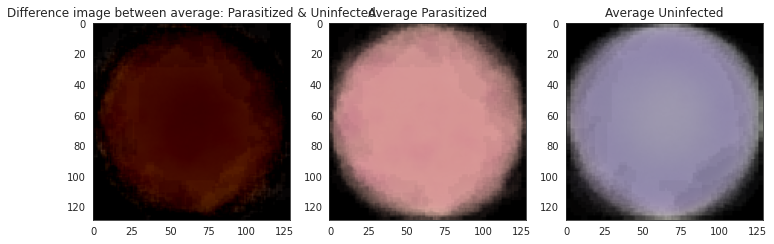

In [37]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='Parasitized', label_2='Uninfected',
                                        figsize=(12,10),
                                        save_image=True
                                        )

---

## Image Montage

In [38]:
import itertools
import random
sns.set_style("white")

# logic
# if label exists in the folder
  # check if your montage space is greater tha nsubset size
  # create list of axes indices based on nrows and ncols
  # create a Figure and display images
    # in this loop, load and plot given image


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15,10)):
  

  labels = os.listdir(dir_path)

  # subset the class you are interested to display
  if label_to_display in labels:

    # checks if your montage space is greater than subset size
    images_list = os.listdir(dir_path+'/'+ label_to_display)
    if nrows * ncols < len(images_list):
      img_idx = random.sample(images_list, nrows * ncols)
    else:
      print(
          f"Decrease nrows or ncols to create your montage. \n"
          f"There are {len(images_list)} in your subset. "
          f"You requested a montage with {nrows * ncols} spaces")
      return
    

    # create list of axes indices based on nrows and ncols
    list_rows= range(0,nrows)
    list_cols= range(0,ncols)
    plot_idx = list(itertools.product(list_rows,list_cols))


    # create a Figure and display images
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize)
    for x in range(0,nrows*ncols):
      img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
      img_shape = img.shape
      axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
      axes[plot_idx[x][0], plot_idx[x][1]].set_title(f"Width {img_shape[1]}px x Height {img_shape[0]}px")
      axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
      axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
    plt.tight_layout()
    plt.show()


  else:
    print("The label you selected doesn't exist.")
    print(f"The existing options are: {labels}")

Run Montage in all labels

Parasitized


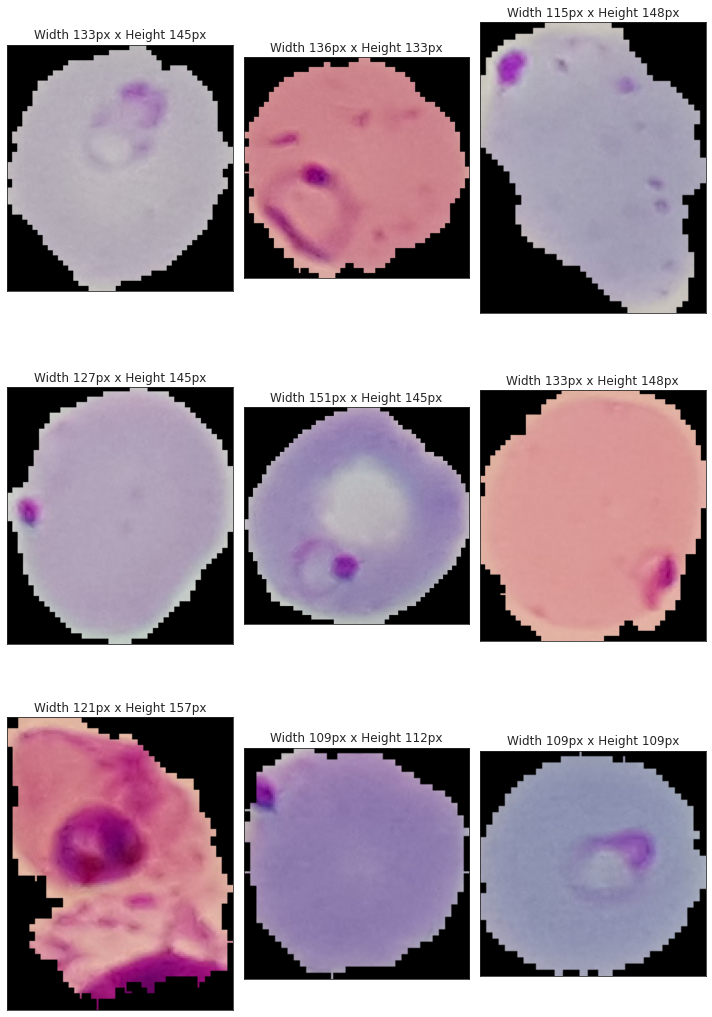



Uninfected


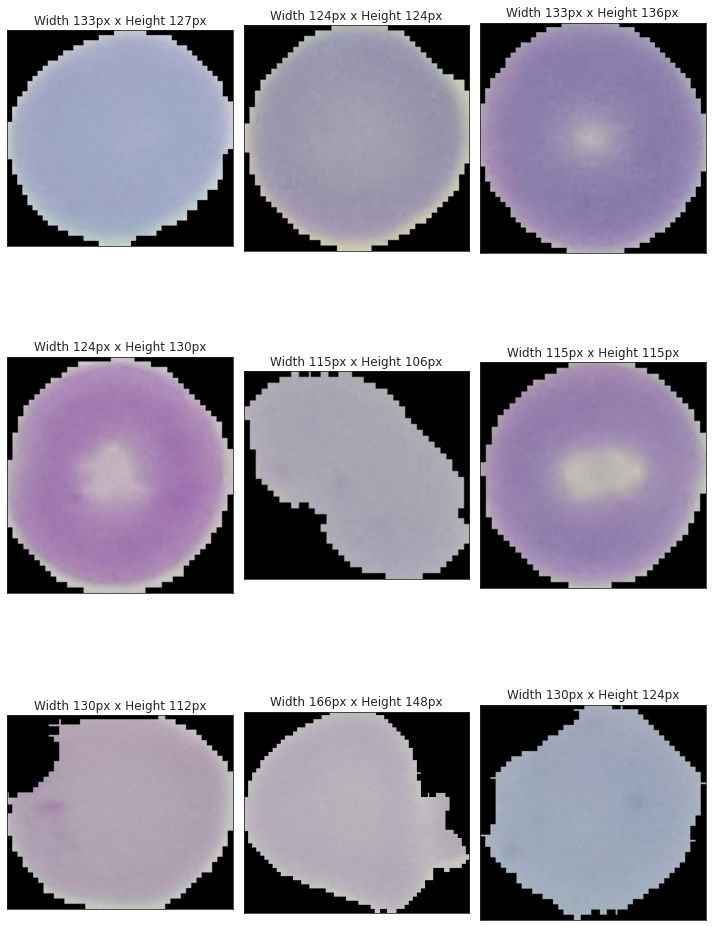

In [39]:
for label in labels:
  print(label)
  image_montage(dir_path= train_path,
                label_to_display= label,
                nrows=3, ncols=3,
                figsize=(10,15)
                )
  print("\n")

---

# Congratulations

---